In [1]:
!gsutil -m cp gs://rhyme_storage/model/cats_vs_dogs.h5 .

Copying gs://rhyme_storage/model/cats_vs_dogs.h5...
\ [1/1 files][  8.9 MiB/  8.9 MiB] 100% Done                                    
Operation completed over 1 objects/8.9 MiB.                                      


In [2]:
import tensorflow as tf

model = tf.keras.models.load_model('cats_vs_dogs.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [6]:
classes = ['Cat', 'Dog']

def display_pred(image_path):
    plt.imshow(plt.imread(image_path))
    
    x = tf.keras.preprocessing.image.load_img(image_path, 
                                            target_size=(128,128))
    x = tf.keras.preprocessing.image.img_to_array(x)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    
    pred = model.predict(x)[0]
    
    plt.title('Pred: {}'.format(classes[int(pred>0.5)]))
    plt.show()
    
    print(pred)

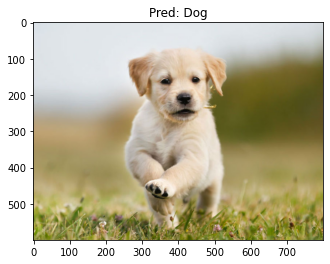

[0.9987244]


In [7]:
images = ['images/cat1.jpg', 'images/cat2.jpg', 'images/dog1.jpg', 'images/dog2.jpg']

display_pred(images[2])

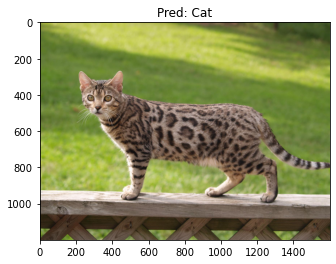

[0.00043299]


In [8]:
display_pred(images[1])

In [9]:
%%writefile prediction.py

import tensorflow as tf
import numpy as np
import os
import base64

MODEL_NAME = 'cats_vs_dogs.h5'
CLASS_NAMES = ['Cat', 'Dog']

class CatsVsDogsPrediction:
    def __init__(self, model):
        self.model = model
        
    def _preprocess(self, instances, size=128):
        num_examples = len(instances)
        x_batch = np.zeros((num_examples, size, size, 3))
        for i in range(num_examples):
            x = np.array(bytearray(base64.b64decode(instances[i])))
            x = np.reshape(x, (size, size, 3))
            x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
            x_batch[i] = x
        return x_batch
    
    def _postprocess(sefl, preds):
        results = []
        for i, pred in enumerate(preds):
            p = np.squeeze(pred)
            results.append({
                'index': i,
                'class_name': CLASS_NAMES[int(p > 0.5)],
                'raw_value': '{:.4f}'.format(p)
            })
        return results
    
    def predict(self, instances, **kwargs):
        if 'size' in kwargs:
            size = int(kwargs.get('size'))
        else:
            size = 128
        # Preprocess
        x_batch = self._preprocess(instances, size)
        # Predict
        preds = self._model.predict(x_batch)
        # Postprocess
        results = self._postprocess(preds)
        return results
        
    @classmethod
    def from_path(cls, model_dir):
        model = tf.keras.models.load_model(os.path.join(model_dir, MODEL_NAME))
        return cls(model)
    
    

Writing prediction.py


In [10]:
%%writefile setup.py
from setuptools import setup

setup(
    name='cats_vs_dogs',
    version='0.0.1',
    include_package_data=False,
    scripts = ['prediction.py']
)

Writing setup.py


In [11]:
!python setup.py sdist --formats=gztar

running sdist
running egg_info
creating cats_vs_dogs.egg-info
writing cats_vs_dogs.egg-info/PKG-INFO
writing dependency_links to cats_vs_dogs.egg-info/dependency_links.txt
writing top-level names to cats_vs_dogs.egg-info/top_level.txt
writing manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'
reading manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'
writing manifest file 'cats_vs_dogs.egg-info/SOURCES.txt'

running check


creating cats_vs_dogs-0.0.1
creating cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying files to cats_vs_dogs-0.0.1...
copying prediction.py -> cats_vs_dogs-0.0.1
copying setup.py -> cats_vs_dogs-0.0.1
copying cats_vs_dogs.egg-info/PKG-INFO -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/SOURCES.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/dependency_links.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
copying cats_vs_dogs.egg-info/top_level.txt -> cats_vs_dogs-0.0.1/cats_vs_dogs.egg-info
Writing cats_vs_dogs-0

In [12]:
!gsutil cp dist/cats_vs_dogs-0.0.1.tar.gz gs://rhyme_storage/dist

Copying file://dist/cats_vs_dogs-0.0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      


In [13]:
from googleapiclient import discovery
from PIL import Image
import os
import base64

In [14]:
service = discovery.build('ml', 'v1', cache_discovery=False)

In [25]:
def get_pred_from_model(body, projec_name, model_name):
    return service.projects().predict(
        name='projects/{}/models/{}'.format(projec_name, model_name),
        body=body
    ).execute()

In [26]:
project_name = 'rhyme-280806' #project ID on GCP
model_name = 'cats_vs_dogs' #model name

In [27]:
images

['images/cat1.jpg', 'images/cat2.jpg', 'images/dog1.jpg', 'images/dog2.jpg']

In [28]:
instances = []
size = 128

for image in images:
    img = Image.open(image)
    img = img.resize((size, size), Image.ANTIALIAS)
    
    instances.append(
        base64.b64encode(img.tobytes()).decode()
    )
    img.close()

In [29]:
body = {
    'instances': instances,
    'size': size
}

In [30]:
response = get_pred_from_model(body, project_name, model_name)

In [31]:
response

{'error': 'Prediction failed: unknown error.'}

In [32]:
response

{'error': 'Prediction failed: unknown error.'}